In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
'''
This is a trail to test whether it is approachable to do surface modeling in single brain region.
'''
import time as t0
import matplotlib.pyplot as plt
from tvb.simulator.lab import *
import pandas as pd
from datetime import date
import dfa
import os
import numpy as np
from one_region_simu import *
from plot_util import *

In [3]:
simulation_mode = 'stimulation'
data_folder = os.path.join(os.getcwd(), 'data')
ray_folder = os.path.join(data_folder,'ray_results')
today = date.today().isoformat()
exp_folder = os.path.join(ray_folder, today+simulation_mode)
os.makedirs(exp_folder, exist_ok=True)

In [4]:
params = config_params(c_ee=7)
region = config_one_region()

WARNING  File 'hemispheres' not found in ZIP.


### Configure the surface

In [5]:
source_path = '/mnt/user/drive/My Libraries/tutorials&explorations/data/cortex/V1_177.zip'
mapping_path = '/mnt/user/drive/My Libraries/tutorials&explorations/data/cortex/regionMapping_177_1.txt'
local_connectivity_path = '/mnt/user/drive/My Libraries/tutorials&explorations/data/cortex/local_connectivity_177.mat'

In [6]:
#Initialise a surface
surf = surfaces.CorticalSurface.from_file(source_file=source_path)
surf.configure()
    
default_cortex = cortex.Cortex.from_file(source_file=source_path, region_mapping_file=mapping_path)
default_cortex.coupling_strength = np.array([2**-10])
default_cortex.local_connectivity = local_connectivity.LocalConnectivity.from_file(local_connectivity_path)
default_cortex.region_mapping_data.connectivity = region
default_cortex.region_mapping_data.surface = surf
default_cortex.configure()

In [120]:
stimulation = True
stim_size = 150
dt = 0.1

In [121]:
import random

In [134]:
from tvb.datatypes.equations import TemporalApplicableEquation
from tvb.basic.neotraits.api import Attr, Final
class SinglePulse(TemporalApplicableEquation):
    """
    A pulse train , offset with respect to the time axis.

    **Parameters**:
    
    * dT     :  pulse repetition period
    * onset         :  time of the first pulse
    * amp           :  amplitude of the pulse
    unit: milliseconds
    """

    equation = Final(
        label="Pulse Train",
        default="where((var>=onset)&((var-onset) < dT), amp, 0)",
        doc=""":math:`\\left\\{{\\begin{array}{rl}amp,&{\\text{if }} ((var-onset) < dT \\and var > onset\\\\0,&{\\text{otherwise }}\\end{array}}\\right.`""")

    parameters = Attr(
        field_type=dict,
        default=lambda: {"dT": 0.1, "amp": 0.001, "onset": 10},
        label="Pulse Train Parameters")

In [135]:
if stimulation:
    # Define a spatial pattern
    # Define a stimulus
    # eqn_t = equations.Alpha()  # belongs to a family of exponential function, used for visual stimulus
    # eqn_t.parameters['onset'] = 200  # ! Time point of stimulus onset!
    # eqn_t.parameters['alpha'] = 43#0.25
    # eqn_t.parameters['beta'] = 12#0.02
    eqn_t = SinglePulse()
    eqn_t.parameters['onset'] = 200  # ! Time point of stimulus onset!
    eqn_s = equations.DiscreteEquation()
    
    deck = list(range(1, default_cortex.surface.number_of_vertices))
    random.shuffle(deck)
    focal = np.array(deck[:stim_size])
    stimulus = patterns.StimuliSurface(surface=default_cortex.surface,
                                       focal_points_triangles=focal,
                                       temporal=eqn_t,
                                       spatial = eqn_s
                                       # space = space
                                      )

    # stimulus.configure_space()  # compute the distance between regions # ? why np.where(stimulus.space==0) gives 114 when focal is set to 123? Also there're some points == inf.
    stimulus.configure_time(np.arange(0.,500, dt))  # apply a stimulus at 25s
    # plot_pattern(stimulus)

In [136]:
stimulus.focal_points_triangles

array([135,  93, 105,  18,  42,  82,  13,  54, 139,  70,  67,  87,  16,
       159,  77, 145,  96,  15,   7, 121, 110,  14,  35,  78,  61,  21,
       158,   6,  95,  53, 136,  11,  60, 115,  79,  91, 165, 108,  80,
       164,  48, 163, 160,  85, 106, 167, 123, 134,  37, 171,   2, 174,
       130, 126,  28, 128, 102,  50,  56, 133, 122, 172,  19,  69, 168,
        57,  46,  24,  99,  64,  52,  75, 142,  59,  89,  86,  43,  98,
       118,  94, 175,   9,  51, 112,  20,  34,   4, 162, 114, 156,  68,
        26,  90,  17,  62,  25,  22, 150,   5, 169, 137, 148, 124, 119,
         3, 132,  92,  65, 144, 153,  39,  32,  38, 146, 120,  47, 109,
        55, 143,  12,  73,  97,  58,   1, 104, 161, 129, 157, 138, 170,
        71,  81,  33, 101,  36, 141,  45, 166,  63,  66, 100, 155,  30,
       152,  41, 113,  40,  84, 147, 154])

In [137]:
stimulus._temporal_pattern[0,101]

0.0

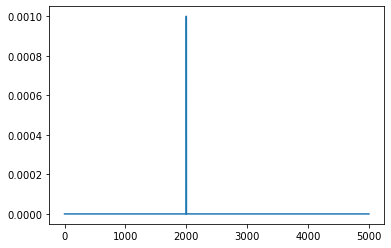

In [138]:
plt.figure()
tp = np.squeeze(stimulus._temporal_pattern)
plt.plot(tp)
# plt.xlim([0,800])

In [139]:
# find the peak of the stimu'
from scipy.signal import find_peaks
find_peaks(tp)

(array([2000]), {})

stimulus.configure_space()
time = r_[1e3:2e3:10.0]
stimulus.configure_time(time)
pattern = stimulus()
imshow(pattern, interpolation='none')
xlabel('Time')
ylabel('Space')
colorbar()

In [140]:
# specify the coupling
c=coupling.Sigmoidal()
integ_mode = 'deterministic'
if integ_mode == 'stochastic':
    # nois = noise.Multiplicative(ntau=params['ntau'], nsig = params['nsig'], b=equations.Gaussian())  # ? Do we need to optimize ntau?
    # nois.configure_coloured(dt=0.1, shape=1)  # ? shape?? 
    # nois = noise.Multiplicative(nsig = params['nsig'], b=equations.Gaussian())
    nois = noise.Multiplicative(nsig = params['nsig'], b=equations.Gaussian(parameters={"amp": 1.0,
                                                                                  "sigma": params['sigma'],
                                                                                  "midpoint": 0.0,
                                                                                  "offset": 1.0}))
    integ = integrators.HeunStochastic(dt=0.1, noise=nois)
elif integ_mode == 'deterministic':
    integ = integrators.HeunDeterministic(dt=0.1)
else:
    raise ValueError("`integ_mode` should be either 'stochastic' or 'deterministic'!")

mod = config_model(params)
#Initialise some Monitors with period in physical time
# TODO configure monitor for each node after optimization is done
mon_savg = monitors.SpatialAverage(period=dt)
sim = simulator.Simulator(model = mod, connectivity = region,
                      coupling = c, 
                      integrator = integ, monitors = (mon_savg,),
                      simulation_length = 500,
                          stimulus = stimulus,
                      surface = default_cortex)
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 6820a186-07a1-4294-b8ae-734ed854bead
coupling,Sigmoidal gid: 6398261e-4f6c-4516-847b-4af540f1ad0b
gid,UUID('c603e7da-9069-47ac-9075-6d7da2adc3b2')
initial_conditions,None
integrator,HeunDeterministic gid: 14ee57b8-8282-407e-8cc3-a4eb8bdaf5d5
model,WilsonCowan gid: 8086cd02-5b17-471a-bdf1-d4ef806c35b8
monitors,"(,)"
simulation_length,500.0


## Pack the stimulation

In [21]:
tic = t0.time()

In [85]:
data_folder = os.path.join(os.getcwd(),'data')
params = config_params(nsig=0.0004, stim_size=50, sigma=1, c_ee=11.57199543729056,c_ei= 10.307919639315172,
                        c_ie= 9.477017434965216,c_ii=7.4836638161762013,a_e=1.3, b_e=2.8,
                        c_e=7.0,a_i=2.0,alpha_e=1)
# params = config_params(nsig=0.00105, stim_size=170, sigma=0.25502,c_ee=14.995,c_ie=7.818)
region = config_one_region()
surface = config_surface(region,surface = True)
stimulus = config_stimulus(params, surface, onset=600, mode= 'SinglePulse', amp=0.001, dT=0.1)
sim = config_simulator(params, region, surface,integ_mode= 'stochastic',stimulus=stimulus,simu_length = 900)

WARNING  File 'hemispheres' not found in ZIP.


In [86]:
savg_time, savg_data = run_simulation(sim, params, return_signal=True)

In [87]:
len(sim.stimulus.focal_points_triangles)

50

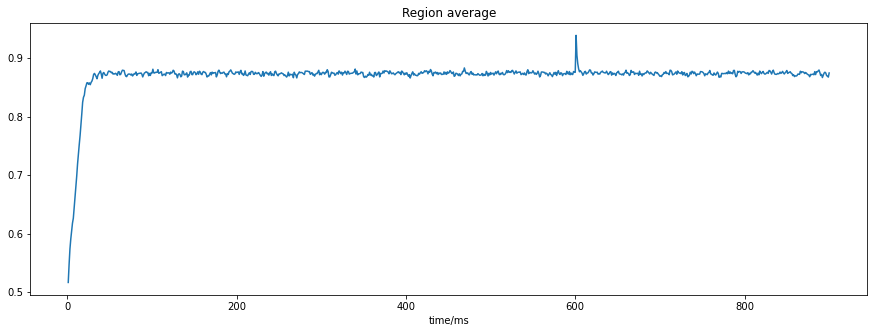

In [88]:
# plot_result(time_s, SAVG, [5000,15000])
plot_result(savg_time, savg_data)

In [35]:
toc = t0.time() - tic
print('Elapsed:',toc)

Elapsed: 47.743064880371094


In [9]:
# df = pd.read_csv(result_name, header = None)
# total_rows=len(df.axes[0])
# print("Number of Rows: "+str(total_rows))
# df.tail()